# IcoME2019_网络教育舆情情感模型

作者:李坦、郭栩宁、黄静玉、李彤彤  作者单位：天津师范大学  300387   通信邮箱：litanyouxiang@foxmail.com

本研究抓取新浪微博博文3万条，其中人工标记1.5万条，无标记1.5万条。标记文本中10000条用于模型训练，5000条用于测试。word2vec训练采用文本为1.5W（无标注）+1W（有标注）。模型采用分层支持向量机，共两层次，第一层用于主客观分类（模型名称:obj_sub_model），第二层是情绪分类（模型名称：emotion_model）。
程序主要分为以下几部分：文本预处理（函数：text_preces()）、分词与停用词去除（函数：cut_word()）、词向量（函数word2vec()）

# 0.导入必要的包

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plot
get_ipython().run_line_magic('matplotlib', 'inline')#图形出现在Notebook里而不是新窗口
import importlib,sys 
importlib.reload(sys)

<module 'sys' (built-in)>

# 1.文本预处理

## 1.1文本读取

In [4]:
#文本读取
dpath="../data/"
data = pd.read_csv(dpath+"unlabled.txt",delimiter='\t')
data.head()

,Weibo TXT
0,#不要报考太原师范学院#顶上去，坚持到高考结束 ?
1,//@你好我是毛线热巴的专属无脸男:#太原师范回应 未发生暴力行为# #李梓瑶# #太师校园...
2,#太原# #李梓瑶# #太原师范回应 未发生暴力行为# #赵湘# #不要报考太原师范学院# ...
3,//@江宁杂志蛾://@言和的肥皂://@言和的肥皂 ://@不刮纸 :#太原师范学院校园暴...
4,#欺凌未成年人获刑1年半#这个热搜出现的时间刚好…… #太原师范学院# 虽然不是未成年...


In [3]:
data.shape

(123336, 1)

In [5]:
#单独取出TXT列进行文本预处理
preproce_data=data["Weibo TXT"]
preproce_data.head()

0                            #不要报考太原师范学院#顶上去，坚持到高考结束 ?
1    //@你好我是毛线热巴的专属无脸男:#太原师范回应 未发生暴力行为# #李梓瑶# #太师校园...
2    #太原# #李梓瑶# #太原师范回应 未发生暴力行为# #赵湘# #不要报考太原师范学院# ...
3    //@江宁杂志蛾://@言和的肥皂://@言和的肥皂 ://@不刮纸 :#太原师范学院校园暴...
4    #欺凌未成年人获刑1年半#这个热搜出现的时间刚好……    #太原师范学院# 虽然不是未成年...
Name: Weibo TXT, dtype: object

## 1.2文本预处理 

In [6]:
import re
new_datas=[]
for i in range(len(preproce_data)):
    new_datas.append(preproce_data[i])#此处处理的目的是将pandas格式的转化成列表的，方便函数调用

#预处理函数处理包括特殊字符的文本,注意此处的输入为列表
def text_preces(new_datas):
    for i in range(len(new_datas)):
        new_datas[i] = re.sub("@([\s\S]*?):","",new_datas[i])  # 去除@ ...：
        new_datas[i] = re.sub("\【([\S\s]*?)\】","",new_datas[i])  # 【...】
        new_datas[i] = re.sub("\[([\S\s]*?)\]","",new_datas[i])  # 【...】
        new_datas[i] = re.sub("\#([\S\s]*?)\#","",new_datas[i])  # #...#
        new_datas[i] = re.sub("@([\s\S]*?) ","",new_datas[i])  # 去除@某个公众人物的特殊标记,如@王胜男
        new_datas[i] = re.sub("//@([\s\S]*?) ","",new_datas[i])  # 去除@某个公众人物的特殊标记,如@王胜男
        new_datas[i] = re.sub("//([\s\S]*?) ","",new_datas[i])  # 去除@某个公众人物的特殊标记,如@王胜男
        new_datas[i] = re.sub("客户端","",new_datas[i])#去除由于采集造成的无关文字
        new_datas[i] = re.sub("回复","",new_datas[i])#去除由于采集造成的无关文字
        new_datas[i] = re.sub("展开全文","",new_datas[i])#去除由于采集造成的无关文字
        new_datas[i] = re.sub("收起全文","",new_datas[i])#去除由于采集造成的无关文字
        new_datas[i] = re.sub("转发微博","",new_datas[i])#去除由于采集造成的无关文字
        new_datas[i] = re.sub("↓","",new_datas[i])#去除由于采集造成的无关文字 
        new_datas[i] = re.sub("→","",new_datas[i])#去除由于采集造成的无关文字
        new_datas[i] = re.sub("http","",new_datas[i])#去除由于采集造成的无关文字
        new_datas[i] = re.sub("WEIBO_TXT","",new_datas[i])#去除由于采集造成的无关文字
        new_datas[i] = re.sub(",抱歉，由于作者设置，你暂时没有这条微博的查看权限哦。查看帮助：网页链接","",new_datas[i])#去除由于采集造成的无关文字
        new_datas[i] = re.sub(",抱歉，此微博已被作者删除。查看帮助：网页链接","",new_datas[i])#去除由于采集造成的无关文字
    return new_datas
#函数调用
new_datas=text_preces(new_datas)

## 1.3中文分词 

In [8]:
#中科院分词系统，不采用北京大学分词系统的原因是北京大学分词系统分词速度较慢，虽然pynlpir分词的精度不高于pkuseg但是我们通过构建分词词典
#促进其分词精确度
import pynlpir
import codecs

#自建分词词典，促进其分词精确度
def user_cut_word():
    from ctypes import c_char_p
    pynlpir.nlpir.AddUserWord(c_char_p("太原师范学院".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("微博".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("热搜".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("校园霸凌".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("校园暴力".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("霸凌".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("施暴".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("玩闹".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("公道话".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("扫黑除恶".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("装死".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("热度".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("辣鸡".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("发消息".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("女学生".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("打黑".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("彻查".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("保护伞".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("骚操作".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("拿回".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("实名".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("熊孩子".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("寻衅滋事罪".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("爆料".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("遭受".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("妄为人师".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("天津财经大学".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("心存敬意".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("龌龊".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("细思极恐".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("热议".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("帖子".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("封禁".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("涉事".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("发帖".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("超话".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("大事化小，小事化了".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("一手好牌".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("学弟学妹".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("欲盖弥彰".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("摔门".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("链接".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("不作声".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("gnqg".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("gms".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("gnbj".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("gwz".encode()))
    pynlpir.nlpir.AddUserWord(c_char_p("gjtgj".encode()))
    
clear_data=open('../data/clear_data.txt','w',encoding='utf-8')   
#分词函数
def cut_word(sentence):
    pynlpir.open() #分词词典打开
    user_cut_word() #短暂关闭自定义词典试试目的是和北京大学分词词典进行比对
    sentments=pynlpir.segment(sentence)
    all_sentence=[]  #承载切分成功的所有词，包括停用词和标点符号等
    for segment in sentments:
        all_sentence.append(segment[0]) #将切分的词加入其中
    f_stopwords=codecs.open('../data/stop_words.txt','r',encoding='utf-8')
    stopwords=f_stopwords.readlines()#停用词加载
    new_sentence=[]  #承载出去停用词的词组
    for w in all_sentence:
        if (w+'\r\n') not in stopwords:
            new_sentence.append(' '+w)   
        else:
            continue
    pynlpir.close()  #分词关闭
    for i in range(len(new_sentence)):
        clear_data.write(new_sentence[i])
    clear_data.write("\n")
    return new_sentence

In [9]:
cut_new_words=[]#承接的是分词后的文档
for i in range(len(new_datas)):
    new_sentence=cut_word(new_datas[i])#调用函数
    cut_new_words.append(new_sentence)

KeyboardInterrupt: 

In [11]:
cut_new_words

[[' 顶', ' 上去', ' 坚持', ' 高考', ' 结束'],
 [],
 [],
 [' 点',
  ' 渣',
  ' 浪',
  ' 一直',
  ' 限',
  ' 热度',
  ' 一直',
  ' 降',
  ' 热搜',
  ' 热心',
  ' 网友',
  ' 提供',
  ' 代',
  ' 视频',
  ' 通话',
  ' 发布',
  ' 十',
  ' 分钟',
  ' 完整',
  ' 版本',
  ' 全部',
  ' 听',
  ' 完',
  ' 再',
  ' 做',
  ' 评断',
  ' 解释',
  ' 下',
  ' 湘北',
  ' 高中',
  ' 年',
  ' 十',
  ' 班',
  ' 微博',
  ' 视频'],
 [' 热搜',
  ' 出现',
  ' 时间',
  ' 未成年',
  ' 欺凌',
  ' 校园',
  ' 欺凌',
  ' 学校',
  ' 单方面',
  ' 处理',
  ' 权利',
  ' 压',
  ' 热搜',
  ' 权利'],
 [' 报考',
  ' 太原师范学院',
  ' 校园暴力',
  ' 试点',
  ' 学校',
  ' 山西',
  ' 公安',
  ' 无动于衷',
  ' 微博',
  ' 下',
  ' 直接',
  ' 设置',
  ' 评论',
  ' 喊',
  ' 扫黑除恶',
  ' 口号',
  ' 一边',
  ' 装死',
  ' 作',
  ' 声'],
 [' 强烈', ' 要求', ' 走', ' 刑事', ' 诉讼'],
 [' 处理', ' 编', ' 一个', ' 谎', ' 谎', ' 兜', ' 住'],
 [' 点',
  ' 渣',
  ' 浪',
  ' 一直',
  ' 限',
  ' 热度',
  ' 一直',
  ' 降',
  ' 热搜',
  ' 热心',
  ' 网友',
  ' 提供',
  ' 代',
  ' 视频',
  ' 通话',
  ' 发布',
  ' 十',
  ' 分钟',
  ' 完整',
  ' 版本',
  ' 全部',
  ' 听',
  ' 完',
  ' 再',
  ' 做',
  ' 评断',
  ' 解释',
  ' 下',
  ' 湘北',
  ' 

# 2.向量化与降维

## 2.1文本向量化 

In [62]:
from gensim.models import word2vec
import logging

logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)
sentences = word2vec.Text8Corpus("../data/clear_data.txt")  # 注意，需要对分词后的语料进行加载，我们通过上一轮文件的读写的方式进行
model = word2vec.Word2Vec(sentences,size =400,workers =10)  # 训练skip-gram模型
# 保存模型，以便重用
model.save("public_opinion_word2vec_2.model")

c:\users\crq\appdata\local\programs\python\python36\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "
2019-07-09 17:23:49,075 : INFO : collecting all words and their counts
c:\users\crq\appdata\local\programs\python\python36\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-07-09 17:23:49,084 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-07-09 17:23:49,723 : INFO : collected 79938 word types from a corpus of 1674314 raw words and 168 sentences
2019-07-09 17:23:49,724 : INFO : Loading a fresh vocab

2019-07-09 17:33:46,196 : INFO : EPOCH 1 - PROGRESS: at 91.07% examples, 2313 words/s, in_qsize 15, out_qsize 0
2019-07-09 17:33:59,592 : INFO : EPOCH 1 - PROGRESS: at 91.67% examples, 2277 words/s, in_qsize 14, out_qsize 0
2019-07-09 17:34:01,882 : INFO : EPOCH 1 - PROGRESS: at 92.86% examples, 2298 words/s, in_qsize 12, out_qsize 0
2019-07-09 17:34:02,979 : INFO : EPOCH 1 - PROGRESS: at 93.45% examples, 2308 words/s, in_qsize 11, out_qsize 0
2019-07-09 17:34:04,804 : INFO : EPOCH 1 - PROGRESS: at 94.64% examples, 2330 words/s, in_qsize 9, out_qsize 1
2019-07-09 17:34:04,805 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-07-09 17:34:08,657 : INFO : EPOCH 1 - PROGRESS: at 95.24% examples, 2330 words/s, in_qsize 8, out_qsize 1
2019-07-09 17:34:08,658 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-07-09 17:34:17,159 : INFO : EPOCH 1 - PROGRESS: at 95.83% examples, 2305 words/s, in_qsize 7, out_qsize 1
2019-07-09 17:34:17,163 : INFO : work

2019-07-09 17:44:41,137 : INFO : EPOCH 2 - PROGRESS: at 91.67% examples, 2251 words/s, in_qsize 14, out_qsize 0
2019-07-09 17:44:42,782 : INFO : EPOCH 2 - PROGRESS: at 93.45% examples, 2288 words/s, in_qsize 11, out_qsize 0
2019-07-09 17:44:45,649 : INFO : EPOCH 2 - PROGRESS: at 94.64% examples, 2306 words/s, in_qsize 9, out_qsize 1
2019-07-09 17:44:45,650 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-07-09 17:44:54,001 : INFO : EPOCH 2 - PROGRESS: at 95.24% examples, 2290 words/s, in_qsize 8, out_qsize 1
2019-07-09 17:44:54,003 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-07-09 17:44:57,180 : INFO : EPOCH 2 - PROGRESS: at 95.83% examples, 2284 words/s, in_qsize 7, out_qsize 1
2019-07-09 17:44:57,182 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-07-09 17:45:07,052 : INFO : EPOCH 2 - PROGRESS: at 96.43% examples, 2263 words/s, in_qsize 6, out_qsize 1
2019-07-09 17:45:07,057 : INFO : worker thread finished; aw

2019-07-09 17:54:23,682 : INFO : EPOCH 3 - PROGRESS: at 85.12% examples, 2325 words/s, in_qsize 19, out_qsize 0
2019-07-09 17:54:29,966 : INFO : EPOCH 3 - PROGRESS: at 85.71% examples, 2315 words/s, in_qsize 20, out_qsize 0
2019-07-09 17:54:31,447 : INFO : EPOCH 3 - PROGRESS: at 86.90% examples, 2340 words/s, in_qsize 19, out_qsize 0
2019-07-09 17:54:32,742 : INFO : EPOCH 3 - PROGRESS: at 87.50% examples, 2351 words/s, in_qsize 20, out_qsize 0
2019-07-09 17:54:36,304 : INFO : EPOCH 3 - PROGRESS: at 89.29% examples, 2383 words/s, in_qsize 18, out_qsize 0
2019-07-09 17:54:59,066 : INFO : EPOCH 3 - PROGRESS: at 89.88% examples, 2306 words/s, in_qsize 17, out_qsize 0
2019-07-09 17:55:01,486 : INFO : EPOCH 3 - PROGRESS: at 91.07% examples, 2327 words/s, in_qsize 15, out_qsize 0
2019-07-09 17:55:07,864 : INFO : EPOCH 3 - PROGRESS: at 91.67% examples, 2317 words/s, in_qsize 14, out_qsize 0
2019-07-09 17:55:09,544 : INFO : EPOCH 3 - PROGRESS: at 92.86% examples, 2340 words/s, in_qsize 12, out_

2019-07-09 18:06:05,819 : INFO : EPOCH 4 - PROGRESS: at 95.83% examples, 2286 words/s, in_qsize 7, out_qsize 1
2019-07-09 18:06:05,822 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-07-09 18:06:13,954 : INFO : EPOCH 4 - PROGRESS: at 96.43% examples, 2271 words/s, in_qsize 6, out_qsize 1
2019-07-09 18:06:13,957 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-07-09 18:06:14,396 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-07-09 18:06:14,430 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-07-09 18:06:16,260 : INFO : EPOCH 4 - PROGRESS: at 98.21% examples, 2304 words/s, in_qsize 3, out_qsize 1
2019-07-09 18:06:16,261 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-09 18:06:16,340 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-09 18:06:16,897 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-09 18:06:16,906 : INFO

2019-07-09 18:16:45,295 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-07-09 18:16:53,509 : INFO : EPOCH 5 - PROGRESS: at 95.83% examples, 2269 words/s, in_qsize 7, out_qsize 1
2019-07-09 18:16:53,511 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-07-09 18:17:03,227 : INFO : EPOCH 5 - PROGRESS: at 96.43% examples, 2248 words/s, in_qsize 6, out_qsize 1
2019-07-09 18:17:03,228 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-07-09 18:17:03,557 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-07-09 18:17:03,658 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-07-09 18:17:04,194 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-09 18:17:04,251 : INFO : EPOCH 5 - PROGRESS: at 98.81% examples, 2300 words/s, in_qsize 2, out_qsize 1
2019-07-09 18:17:04,252 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-07-09 18:17:05,118 : INFO

In [14]:
#训练完毕，开始进行pos和neg的向量化
from gensim.models import word2vec
import gensim
def getWordVecs(wordList):
    vecs = []
    for word in range(len(wordList)):
        wordList[word] = wordList[word].replace('\n','')
        try:
            vecs.append(model[wordList[word]])
        except KeyError:
            continue
    # vecs = np.concatenate(vecs)
    return np.array(vecs, dtype = 'float')


def buildVecs(filename):
    posInput = []
    with open(filename,"rb") as txtfile:
        # print txtfile
        for lines in txtfile:
            lines=lines.decode()
            lines = lines.split('\n')
            for line in lines:
                pynlpir.open()
                line= pynlpir.segment(line,pos_tagging=False)#这里需要注意的是pos_tagging=False是关闭词性自动标注
                resultList = getWordVecs(line)
                #for each sentence, the mean vector of all its vectors is used to represent this sentence
                if len(resultList) != 0:
                    resultArray = sum(np.array(resultList))/len(resultList)
                    posInput.append(resultArray)

    return posInput

def buildVecs_new(lines):
    for line in lines:
        pynlpir.open()
        line= cut_word(line)#这里需要注意的是pos_tagging=False是关闭词性自动标注
        resultList = getWordVecs(line)
        if len(resultList) != 0:
            resultArray = sum(np.array(resultList))/len(resultList)
            posInput.append(resultArray)        
    return posInput

# load word2vec model
model = word2vec.Word2Vec.load("public_opinion_word2vec_2.model")

c:\users\crq\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [9]:
objInput = buildVecs('../data/object.txt')
subInput = buildVecs('../data/subject.txt')

# use 1 for objective sentiment, 0 for subjective sentiment
obj_sub_y = np.concatenate((np.ones(len(objInput)), np.zeros(len(subInput))))
obj_sub_X = objInput[:]#全部复制
for sub in subInput:
    obj_sub_X.append(sub)
obj_sub_X = np.array(obj_sub_X)

c:\users\crq\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 0: invalid start byte

In [77]:
model = word2vec.Word2Vec.load("public_opinion_word2vec_2.model")
model.most_similar("欺凌")

2019-07-09 18:47:36,916 : INFO : loading Word2Vec object from public_opinion_word2vec_2.model
c:\users\crq\appdata\local\programs\python\python36\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-07-09 18:47:37,658 : INFO : loading wv recursively from public_opinion_word2vec_2.model.wv.* with mmap=None
2019-07-09 18:47:37,659 : INFO : setting ignored attribute vectors_norm to None
2019-07-09 18:47:37,660 : INFO : loading vocabulary recursively from public_opinion_word2vec_2.model.vocabulary.* with mmap=None
2019-07-09 18:47:37,660 : INFO : loading trainables recursively from public_opinion_word2vec_2.model.trainables.* with mmap=None
2019-07-09 18:47:37,661 : INFO : setting ignored attribute cum_table t

[('校园', 0.8825623989105225),
 ('矛盾', 0.8279960751533508),
 ('所谓', 0.8160749673843384),
 ('同流合污', 0.8155376315116882),
 ('侮辱', 0.8127641677856445),
 ('施暴', 0.8124326467514038),
 ('纵容', 0.8114801645278931),
 ('谣言', 0.810608446598053),
 ('素质', 0.8089848160743713),
 ('背后', 0.8058185577392578)]

## 2.2标转化与PCA 

In [78]:
from sklearn.preprocessing import scale
X=scale(obj_sub_X)
print(X)

[[-0.75617841  0.01606397 -0.43476813 ...  1.26874758 -0.58188385
  -0.62030606]
 [-0.53296634 -0.34145975 -0.00695607 ... -0.13584613  0.91205266
  -0.73702022]
 [-1.37994231  0.1663739  -2.61238961 ... -1.02037045  0.03874271
   0.49068457]
 ...
 [-0.66697829 -1.01785793 -0.96583271 ...  0.65987399 -1.73645824
   0.22863314]
 [-0.07752889  1.28574361  0.33046976 ... -0.97517345 -0.78967192
   0.6021749 ]
 [-0.41850355 -0.1880393  -0.43485231 ...  1.05726251 -1.07829695
   0.10049483]]


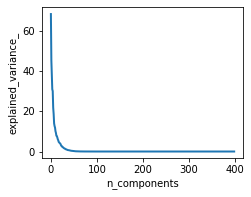

In [79]:
#向量降维
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
n_components = 400
pca=PCA(n_components=n_components)
pca.fit(X)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_') 
X_reduced = PCA(n_components = 400).fit_transform(X)#观察，取前100维度就OK了

# 3.情感模型构建

## 3.1第一层模型构建 

In [15]:
#读取数据，训练集，测试集
dpath="../data/"
objtesty = pd.read_csv(dpath+"objtesty.txt",delimiter='\t')
objtrainy = pd.read_csv(dpath+"objtrainy.txt",delimiter='\t')
#obj_sub_data_train.shape

In [16]:
obj_sub_data_train_vecs=buildVecs('../data/objtrain.txt')
obj_sub_data_test_vecs=buildVecs('../data/objtest.txt')

e:\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [17]:
len(obj_sub_data_train_vecs)

399

In [23]:
# 所需必要的包
from sklearn import metrics
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.externals import joblib

c:\users\crq\appdata\local\programs\python\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### 3.1.1SVM 

In [19]:
from sklearn.svm import SVC 
from sklearn.metrics import classification_report
from sklearn.externals import joblib

clf = SVC(kernel='linear', C=1)
clf.fit(obj_sub_data_train_vecs,objtrainy)

y_predict= clf.predict(obj_sub_data_test_vecs) 
print (classification_report(objtesty, y_predict))
#scores = cross_val_score(clf,obj_sub_data_train_vecs,objtrainy, cv=10)  #cv为迭代次数。
#print(scores)  # 打印输出每次迭代的度量值（准确度）
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))  # 获取置信区间。（也就是均值和方差）
#confusion_matrix()
joblib.dump(clf, 'SVM_1.model')

              precision    recall  f1-score   support

           0       0.72      0.72      0.72        64
           1       0.79      0.79      0.79        87

   micro avg       0.76      0.76      0.76       151
   macro avg       0.76      0.76      0.76       151
weighted avg       0.76      0.76      0.76       151



e:\python36\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['SVM_1.model']

### 3.1.2NB 

In [88]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()   # 使用默认配置初始化朴素贝叶斯
gnb.fit(obj_sub_data_train_vecs,objtrainy)    # 利用训练数据对模型参数进行估计
y_predict = gnb.predict(obj_sub_data_test_vecs)     # 对参数进行预测

#4.获取结果报告

print (classification_report(objtesty, y_predict))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        64
           1       0.79      0.74      0.76        87

   micro avg       0.74      0.74      0.74       151
   macro avg       0.73      0.74      0.73       151
weighted avg       0.74      0.74      0.74       151



e:\python36\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 3.3KNN 

In [89]:
from sklearn.neighbors import KNeighborsClassifier 

knn=KNeighborsClassifier()
knn.fit(obj_sub_data_train_vecs,objtrainy)
#预测
y_predict=knn.predict(obj_sub_data_test_vecs)
print (classification_report(objtesty, y_predict))

e:\python36\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


              precision    recall  f1-score   support

           0       0.64      0.77      0.70        64
           1       0.80      0.69      0.74        87

   micro avg       0.72      0.72      0.72       151
   macro avg       0.72      0.73      0.72       151
weighted avg       0.73      0.72      0.72       151



### 3.4 DT 

In [90]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(obj_sub_data_train_vecs,objtrainy)
y_predict=tree.predict(obj_sub_data_test_vecs)
print (classification_report(objtesty, y_predict))

              precision    recall  f1-score   support

           0       0.59      0.72      0.65        64
           1       0.75      0.63      0.69        87

   micro avg       0.67      0.67      0.67       151
   macro avg       0.67      0.68      0.67       151
weighted avg       0.68      0.67      0.67       151



## 3.2第二层模型构建 

In [20]:
#文件读取与向量化
postrainInput = buildVecs('../data/postrain.txt')
postestInput = buildVecs('../data/postest.txt')
len(postrainInput)

e:\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


549

In [40]:
#读取数据，训练集，测试集
dpath="../data/"
postesty = pd.read_csv(dpath+"postesty.txt",delimiter='\t')
postrainy = pd.read_csv(dpath+"postrainy.txt",delimiter='\t')
postrainy.shape
print(postrainy)

     LABEL
0        0
1        0
2        0
3        0
4        1
5        0
6        0
7        0
8        0
9        1
10       0
11       0
12       0
13       0
14       1
15       0
16       1
17       1
18       1
19       1
20       1
21       0
22       1
23       0
24       0
25       0
26       1
27       1
28       0
29       0
..     ...
519      1
520      0
521      0
522      0
523      0
524      1
525      1
526      1
527      1
528      0
529      0
530      1
531      0
532      0
533      1
534      0
535      0
536      0
537      0
538      1
539      1
540      1
541      0
542      1
543      1
544      0
545      0
546      0
547      1
548      1

[549 rows x 1 columns]


### 3.2.1 SVM 

In [41]:
clf = SVC(kernel='linear', C=1)
clf.fit(postrainInput,postrainy)

y_predict= clf.predict(postestInput) 
print (classification_report(postesty, y_predict))
joblib.dump(clf, 'SVM_2.model')
print(y_predict)

e:\python36\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.78      0.70      0.74       140
           1       0.62      0.72      0.67        96

   micro avg       0.71      0.71      0.71       236
   macro avg       0.70      0.71      0.70       236
weighted avg       0.72      0.71      0.71       236

[1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1
 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1
 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1
 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1
 1 0 1 1 1 0 1 0 1 1 0 1 0 0]


### 3.2.2 NB 

In [29]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()   # 使用默认配置初始化朴素贝叶斯
gnb.fit(postrainInput,postrainy)    # 利用训练数据对模型参数进行估计
y_predict = gnb.predict(postestInput)     # 对参数进行预测

#4.获取结果报告

print (classification_report(postesty, y_predict))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       140
           1       0.57      0.58      0.57        96

    accuracy                           0.65       236
   macro avg       0.64      0.64      0.64       236
weighted avg       0.65      0.65      0.65       236



c:\users\crq\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 3.2.3 KNN 

In [30]:
from sklearn.neighbors import KNeighborsClassifier 

knn=KNeighborsClassifier()
knn.fit(postrainInput,postrainy)
#预测
y_predict=knn.predict(postestInput)
print (classification_report(postesty, y_predict))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       140
           1       0.58      0.54      0.56        96

    accuracy                           0.66       236
   macro avg       0.64      0.64      0.64       236
weighted avg       0.65      0.66      0.65       236



c:\users\crq\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


### 3.2.4 DT 

In [31]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(postrainInput,postrainy)
y_predict=tree.predict(postestInput)
print (classification_report(postesty, y_predict))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       140
           1       0.61      0.59      0.60        96

    accuracy                           0.68       236
   macro avg       0.67      0.67      0.67       236
weighted avg       0.68      0.68      0.68       236



In [80]:
#SVM，使用交叉验证评价模型，关闭ROC评价策略

from sklearn.svm import SVC 
from sklearn import metrics
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.externals import joblib
 
clf = SVC(kernel='linear', C=1)
clf.fit(X_reduced,y)
scores = cross_val_score(clf,X_reduced,y, cv=10)  #cv为迭代次数。
print(scores)  # 打印输出每次迭代的度量值（准确度）
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))  # 获取置信区间。（也就是均值和方差）
joblib.dump(clf, 'SVM_linear.model')
CLF=joblib.load('SVM_linear.model')#模型调用

c:\users\crq\appdata\local\programs\python\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


[0.76923077 0.76623377 0.75324675 0.72727273 0.77922078 0.79220779
 0.81578947 0.78947368 0.85526316 0.80263158]
Accuracy: 0.79 (+/- 0.07)


In [81]:
clf = SVC(kernel='rbf', C=1)
clf.fit(X_reduced,y)
scores = cross_val_score(clf,X_reduced,y, cv=10)  #cv为迭代次数。
print(scores)  # 打印输出每次迭代的度量值（准确度）
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))  # 获取置信区间。（也就是均值和方差）
joblib.dump(clf, 'SVM_rbf.model')


c:\users\crq\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\crq\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\crq\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning

[0.80769231 0.79220779 0.77922078 0.77922078 0.77922078 0.77922078
 0.78947368 0.80263158 0.82894737 0.82894737]
Accuracy: 0.80 (+/- 0.04)


['SVM_rbf.model']

## 3.3 分层模型构建

In [46]:
from sklearn.externals import joblib
def svm_predict(filename):
    filename=filename
    words_vecs=buildVecs(filename)
    CLF_1=joblib.load('SVM_1.model')#模型调用
    CLF_2=joblib.load('SVM_2.model')
    y_predict_all=[]
    result_1=CLF_1.predict(words_vecs)
    for i in result_1:
        if int(result_1[i])==0:
            y_predict=0
        else:
            result_2=CLF_2.predict(words_vecs[i])
            if result_2==0:
                y_predict=-1
            else:
                 y_predict=1
        y_predict_all.append(y_predict)
    print(y_predict_all)

In [77]:
from sklearn.externals import joblib
def svm_predict(filename):
    filename=filename
    words_vecs=buildVecs(filename)
    CLF_1=joblib.load('SVM_1.model')#模型调用
    CLF_2=joblib.load('SVM_2.model')
    y_predict_all=[]
    result_1=CLF_1.predict(words_vecs)
    result_2=CLF_2.predict(words_vecs)
    newresult_1=result_1.tolist()
    newresult_2=result_2.tolist()
    for i in range(len(newresult_1)):
        #print(newresult_1[i])
        if int(newresult_1[i])==0:
            y_predict=0
        else:
            if int(newresult_2[i])==0:
                y_predict=-1
            else:
                 y_predict=1
        y_predict_all.append(y_predict)
    print(y_predict_all)

In [78]:
svm_predict('../data/test.txt')

e:\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


[1, 0, 0, -1, -1, -1, 0, 0, -1, -1, -1, -1, 0, -1, 1, 0, -1, 0, 0, 0, -1, 0, 0, 1, -1, 1, -1, 0, 0, 0, -1, -1, 0, 0, -1, 1, -1, 1, -1, 1, 1, 0, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 0, 1, -1, 0, -1, -1, 1, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, -1, -1, 1, -1, 0, 0, 1, -1, 0, -1, 0, -1, 1, 1, -1, 1, 0, -1, 1, 0, 0, 0, 1, 0, -1, 1, -1, 0, 0, 0, -1, -1, 1, -1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 1, -1, 0, -1, -1]


In [36]:
print(y_predict_all)

NameError: name 'y_predict_all' is not defined